# Tutorial 07 - Frame Extraction and Gaze Visualization

In this tutorial we will look at how to extract individual frame images from the world video using `ffmpeg`, and visualize gaze positions for a specific frame.

1. Extract all frame images from the world video
1. Load exported gaze positions using `Pandas`
1. Visualize image and gaze positions for a frame index

---
> To execute this notebook, download the [sample recording](https://drive.google.com/file/d/1vzjZkjoi8kESw8lBnsa_k_8hXPf3fMMC/view?usp=sharing). Unzip and move it into the `recordings` directory for this repository.

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
rec_dir = Path().joinpath("recordings", "sample_recording_v2").resolve()
assert rec_dir.is_dir(), f"Please download the sample_recording_v2 into recordings/"
rec_dir

PosixPath('/Users/rom/work/pupil-tutorials/recordings/sample_recording_v2')

### Extracting Frames

Most video files generated by Pupil will have a variable frame rate, mirroring the exact frame rate of the incoming frames from the cameras.
A common postprocessing step is extracting every frame from the videos.
You can use a tool like [FFmpeg](https://ffmpeg.org/) for this, but need to keep in mind the variable frame rate.
E.g. for extracting every frame from an exported world video, you can use:
```
ffmpeg -i "/path/to/input/recording/world.mp4" -vsync 0 "/path/to/output/images/frame%06d.png"
```
where the `-vsync 0` option ensures correct handling of the variable frame rate.

In [4]:
# Delete previously extracted frames
!rm -f ./data/extracted_frames/*.png

In [5]:
# Extract individual frames from the world video
!ffmpeg -i "./recordings/sample_recording_v2/world.mp4" -vsync 0 "./data/extracted_frames/frame%06d.png"

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   

### Loading Gaze Data

The sample recording contains an export with `gaze_positions.csv` file; we're using `Pandas` to read the data into a data frame for easy access.

In [6]:
gaze = pd.read_csv(
    rec_dir.joinpath("exports", "000", "gaze_positions.csv")
)
gaze.head(5)

,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center0_3d_z,gaze_normal0_x,gaze_normal0_y,gaze_normal0_z,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z
0,329353.721918,0,0.882190,0.466990,0.588336,329353.722497-0 329353.721339-1,-11.803057,-15.088219,156.329434,17.945316,...,-24.308207,-0.160656,-0.193147,0.967928,-39.437908,15.124464,-21.517594,0.151726,-0.133904,0.979310
1,329353.724421,0,0.882190,0.467034,0.588436,329353.722497-0 329353.726346-1,-11.782673,-15.090093,156.201174,17.945316,...,-24.308207,-0.160656,-0.193147,0.967928,-39.437908,15.124464,-21.517594,0.151938,-0.134148,0.979244
2,329353.726925,0,0.998701,0.466414,0.588739,329353.727503-0 329353.726346-1,-11.883740,-15.070357,155.541515,17.945316,...,-24.308207,-0.161753,-0.194080,0.967558,-39.437908,15.124464,-21.517594,0.151938,-0.134148,0.979244
3,329353.729427,0,0.998701,0.466224,0.589478,329353.727503-0 329353.731352-1,-11.969161,-15.224583,156.042858,17.945316,...,-24.308207,-0.161753,-0.194080,0.967558,-39.437908,15.124464,-21.517594,0.151051,-0.134912,0.979277
4,329353.731931,0,0.996813,0.465450,0.588259,329353.73251-0 329353.731352-1,-12.094622,-14.975118,155.244247,17.945316,...,-24.308207,-0.163125,-0.192832,0.967577,-39.437908,15.124464,-21.517594,0.151051,-0.134912,0.979277


### Visualizing Image and Gaze

In [7]:
FRAME_INDEX = 1601  # Frame index used for visualization

We read the data of the extracted frame image with the given index.

In [8]:
# Get the extracted frame image path for the given index
frame_index_path = Path().resolve()
# Append path to extracted frame directory
frame_index_path = frame_index_path.joinpath("data", "extracted_frames")
# File name matching the "frame%06d.png" template
frame_index_path = frame_index_path.joinpath(f"frame{str(FRAME_INDEX).rjust(6, '0')}.png")
assert frame_index_path.is_file(), f"Can't find frame image at path: {frame_index_path}"

frame_index_image = plt.imread(frame_index_path)
frame_index_image.shape

(720, 1280, 3)

Now we extract the gaze points for the give frame index into an array of `(x, y)` normalized coordinates.

In [9]:
# Get the array of normalized gaze points for the given index
gaze_points = gaze[gaze["world_index"] == FRAME_INDEX]
gaze_points = gaze_points.sort_values(by="gaze_timestamp")
gaze_points = gaze_points[["norm_pos_x", "norm_pos_y"]]
gaze_points = gaze_points.to_numpy()
gaze_points

array([[0.53965116, 0.3851798 ],
       [0.53888162, 0.38354167],
       [0.53859938, 0.38380579],
       [0.5436703 , 0.3888194 ],
       [0.54504616, 0.38551447],
       [0.54779267, 0.38100607],
       [0.55350396, 0.38354754],
       [0.55526815, 0.38281189],
       [0.55959819, 0.39004821],
       [0.55998175, 0.38937488]])

Next, we split the gaze points data into the `x` and `y` component arrays, and denormalize it to the size of the frame image.

In [10]:
# Split gaze points into separate X and Y coordinate arrays
X, Y = gaze_points[:, 0], gaze_points[:, 1]

# Flip the fixation points
# from the original coordinate system,
# where the origin is at botton left,
# to the image coordinate system,
# where the origin is at top left
Y = 1 - Y

# Denormalize gaze points within the frame
H, W = frame_index_image.shape[:-1]
X, Y = X * W, Y * H

X, Y

(array([690.75348981, 689.7684723 , 689.40720446, 695.8979783 ,
        697.65908407, 701.17461296, 708.48506514, 710.74323628,
        716.28567844, 716.77664229]),
 array([442.67054648, 443.84999541, 443.65983426, 440.05003556,
        442.42958032, 445.67562795, 443.84576986, 444.37543713,
        439.16528545, 439.65008745]))

Finally, it's time to plot the image and overlay the gaze data.

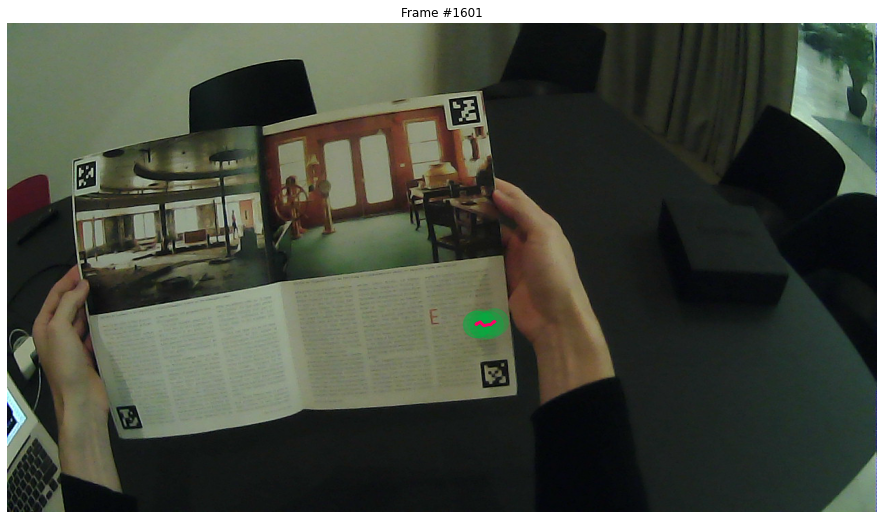

In [11]:
# Plotting configuration
plt.figure(figsize=(16,9))
plt.title(f"Frame #{FRAME_INDEX}")
plt.axis("off")

# Draw the frame image
plt.imshow(frame_index_image)

# Draw the gaze points for the given frame
plt.scatter(X, Y, color=(0.0, 0.7, 0.25), s=700, alpha=0.2)

# Draw the gaze movement line for the given frame
plt.plot(X, Y, color=(1.0, 0.0, 0.4), lw=3)

plt.show()